# KQCircuits PCell Viewer

Lightweight option for viewing/testing pcells under development.

## Configuration

In [1]:
# ------------------------------------------------------------
# IMPORTS
# ------------------------------------------------------------
import sys
import json
import time
import shutil
import logging
from pathlib import Path
from importlib import import_module
from autologging import TRACE

# Python library for handling GDSII files
import gdspy
# Python library for converting SVG files
import cairosvg
# Notebook display tools
from IPython.display import display, Image, SVG
# KLayout standalone Python library  
import klayout.db as pya

# KQCircuits helper modules   
import kqcircuits.util.library_helper as library_helper

logging.basicConfig(
    level=logging.DEBUG, 
    stream=sys.stdout,
    format="%(asctime)s:%(levelname)s:%(name)s:%(funcName)s:%(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)

# ------------------------------------------------------------
# INPUT
# ------------------------------------------------------------
class_name = "ChipXMonsDirectCoupling"
module_name = library_helper.to_module_name(class_name)
# Override default parameters as needed
parameters = {}
# View options 
use_timestamp = False
scale = 0.05
show_gds = False
show_svg = True
show_png = False

# ------------------------------------------------------------
# VIEW CONFIGURATION
# ------------------------------------------------------------
library_name = library_helper.to_library_name(class_name)

# import module
try:
    module = import_module("kqcircuits.elements." + module_name)
except ImportError:
    try:
        module = import_module("kqcircuits.chips." + module_name)
    except ImportError:
        try:
            module = import_module("kqcircuits.test_structures." + module_name)
        except ImportError as e:
            raise Exception("Failed to find module {}.".format(module_name)) from e

# get class
cls = getattr(module, class_name)

# get default parameters
params = cls().get_parameters()
defaults = {}
for p in params:
    defaults[p.name] = p.default if isinstance(p.default, (str, int, float, bool)) else str(p.default)

# print configuration
print("MODULE NAME: {}".format(module_name))
print("CLASS NAME: {}".format(class_name))
print("LIBRARY NAME: {}".format(library_name))
print()
print("PARAMETERS")
print("----------")
print("DEFAULT: {}".format(json.dumps(defaults, indent=2)))
print("INPUT: {}".format(json.dumps(parameters, indent=2)))
print()
print("OPTIONS")
print("----------")
print("USE TIMESTAMP: {}".format(use_timestamp))
print("SCALE: {}".format(scale))
print("SHOW GDS: {}".format(show_gds))
print("SHOW SVG: {}".format(show_svg))
print("SHOW PNG: {}".format(show_png))

MODULE NAME: chip_xmons_direct_coupling
CLASS NAME: ChipXMonsDirectCoupling
LIBRARY NAME: Chip XMons Direct Coupling

PARAMETERS
----------
DEFAULT: {
  "lo": "'b base metal gap wo grid' (2/0)",
  "lp": "'b ground grid avoidance' (11/0)",
  "la": "Annotations (9/0)",
  "a": 10,
  "b": 6,
  "n": 64,
  "r": 100,
  "margin": 5,
  "box": "(0,0;10000,10000)",
  "with_grid": false,
  "lg": "Grid (5/0)",
  "dice_width": 200,
  "name_mask": "M99",
  "name_chip": "CTest",
  "name_copy": "None",
  "text_margin": 100,
  "dice_grid_margin": 100,
  "qubit_spacing": 10,
  "arm_width_a": 24,
  "arm_width_b": 24
}
INPUT: {}

OPTIONS
----------
USE TIMESTAMP: False
SCALE: 0.05
SHOW GDS: False
SHOW SVG: True
SHOW PNG: False


## Images

2020-03-09 15:51:05:DEBUG:kqcircuits.util.parameter_helper.Validator:validate:Validating lo using rules [{'name': 'lo', 'type': 4, 'description': 'Layer optical', 'hidden': False, 'readonly': False, 'unit': None, 'default': 'b base metal gap wo grid' (2/0), 'choices': None, 'required': False}].
2020-03-09 15:51:05:DEBUG:kqcircuits.util.parameter_helper.Validator:validate:Validated lo.
2020-03-09 15:51:05:INFO:kqcircuits.util.library_helper:_create_library:Comparing name Chip Library to cls.LIBRARY_NAME Test Structure Library.
2020-03-09 15:51:05:INFO:kqcircuits.util.library_helper:_create_library:Comparing name Chip Library to cls.LIBRARY_NAME Test Structure Library.
2020-03-09 15:51:05:INFO:kqcircuits.util.library_helper:_create_library:Comparing name Chip Library to cls.LIBRARY_NAME Test Structure Library.
2020-03-09 15:51:05:INFO:kqcircuits.util.library_helper:_create_library:Comparing name Chip Library to cls.LIBRARY_NAME Chip Library.
2020-03-09 15:51:05:DEBUG:kqcircuits.util.libr

/Users/sinaninel/opt/anaconda3/envs/klayout/lib/python3.7/site-packages/gdspy/library.py:1989: UserWarning: [GDSPY] Record type PROPATTR (2B) is not supported.
  self.read_gds(infile, **kwargs)
/Users/sinaninel/opt/anaconda3/envs/klayout/lib/python3.7/site-packages/gdspy/library.py:1989: UserWarning: [GDSPY] Record type PROPVALUE (2C) is not supported.
  self.read_gds(infile, **kwargs)


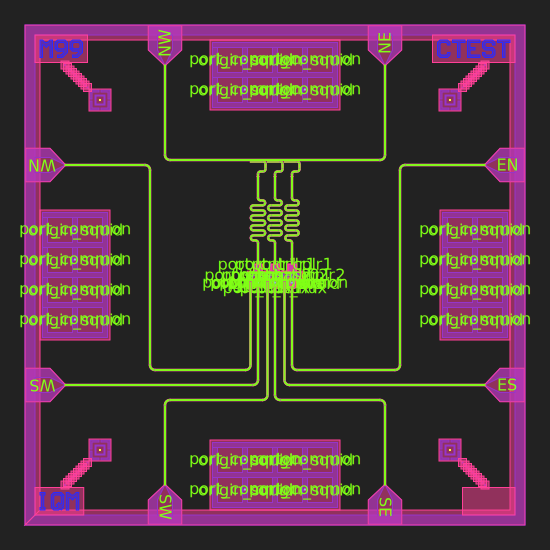

In [2]:
# ------------------------------------------------------------
# IMAGE VARIABLES
# ------------------------------------------------------------

# Derive image directory name
if use_timestamp:
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    dir_name = timestamp + "_" + module_name + "_images"
else:
    dir_name = module_name + "_images"

# Create temporary image directory
dir_path = Path.cwd().parent.joinpath("tmp").joinpath(dir_name)
if dir_path.exists():
    if dir_path.is_dir():
        shutil.rmtree(dir_path)
dir_path.mkdir()

# Define paths for storing image files
gds_path = dir_path.joinpath(module_name + ".gds")
svg_path = dir_path.joinpath(module_name + ".svg")
png_path = dir_path.joinpath(module_name + ".png")

# ------------------------------------------------------------
# CREATE & EXPORT LAYOUT
# ------------------------------------------------------------
layout = pya.Layout()
top = layout.create_cell("top")
cell = cls.create_cell(layout, parameters)

top.insert(pya.DCellInstArray(cell.cell_index(), pya.DTrans()))

# Export to gds
layout.write(str(gds_path))

# Export to svg
if show_svg or show_png:
    gdspy_library = gdspy.GdsLibrary(infile=str(gds_path))
    gdspy_library.cells[library_name.replace(" ", "$")].write_svg(str(svg_path), scaling=scale)

# ------------------------------------------------------------
# VIEW SVG
# ------------------------------------------------------------
if show_svg:
    svg_image = SVG(str(svg_path))
    display(svg_image)

# ------------------------------------------------------------
# VIEW PNG
# ------------------------------------------------------------
if show_png:
    cairosvg.svg2png(url=str(svg_path), write_to=str(png_path))
    png_image = Image(str(png_path))
    display(png_image)

# ------------------------------------------------------------
# VIEW GDS
# ------------------------------------------------------------
if show_gds: gdspy.LayoutViewer()

# clean up gdspy library
gdspy.current_library = gdspy.GdsLibrary()